In [5]:
import os
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 15 12:28:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
ROOT = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [3]:
!cp "/content/gdrive/MyDrive/FAI/TrainTestVal_DS1.zip" /content
!unzip -q "/content/gdrive/MyDrive/FAI/TrainTestVal_DS1.zip" -d /content #Unzip  #Move File from Drive to Colab

In [6]:
!cp "/content/gdrive/MyDrive/FAI/TrainTestVal.zip" /content  #Move File from Drive to Colab
!unzip -q "/content/gdrive/MyDrive/FAI/TrainTestVal.zip" -d /content #Unzip

train = "/content/TrainTestVal/Train/"
test = "/content/TrainTestVal/Test/"
val = "/content/TrainTestVal/Val/"

train_normal = len(os.listdir("/content/TrainTestVal/Train/Tumor/"))
train_tumor = len(os.listdir("/content/TrainTestVal/Train/Normal/"))
print(train_normal)
print(train_tumor)
num_train = train_normal + train_tumor

test_normal = len(os.listdir("/content/TrainTestVal/Test/Tumor/"))
test_tumor = len(os.listdir("/content/TrainTestVal/Test/Normal/"))
print(test_normal)
print(test_tumor)
num_test = test_normal + test_tumor

val_normal = len(os.listdir("/content/TrainTestVal/Val/Tumor/"))
val_tumor = len(os.listdir("/content/TrainTestVal/Val/Normal/"))
print(val_normal)
print(val_tumor)
num_val = val_normal + val_tumor

replace /content/TrainTestVal/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/TrainTestVal/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
4881
3258
611
408
610
407


In [7]:
img_dimensions  = 224
batch_size = 64

train = "/content/TrainTestVal_DS1/Train/"
test = "/content/TrainTestVal_DS1/Test/"
val = "/content/TrainTestVal_DS1/Val/"

In [8]:
train_normal = len(os.listdir("/content/TrainTestVal_DS1/Train/Tumor/"))
train_tumor = len(os.listdir("/content/TrainTestVal_DS1/Train/Normal/"))
print(train_normal)
print(train_tumor)
num_train = train_normal + train_tumor

test_normal = len(os.listdir("/content/TrainTestVal_DS1/Test/Tumor/"))
test_tumor = len(os.listdir("/content/TrainTestVal_DS1/Test/Normal/"))
print(test_normal)
print(test_tumor)
num_test = test_normal + test_tumor

val_normal = len(os.listdir("/content/TrainTestVal_DS1/Val/Tumor/"))
val_tumor = len(os.listdir("/content/TrainTestVal_DS1/Val/Normal/"))
print(val_normal)
print(val_tumor)
num_val = val_normal + val_tumor

1200
1200
150
150
150
150


In [9]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [35]:
img_size=(300,300)
channels=3
batch_size=20
img_shape=(img_size[0], img_size[1], channels)

def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required

gen=ImageDataGenerator(preprocessing_function=scalar)

train_gen=gen.flow_from_directory(directory = train, target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen=gen.flow_from_directory(directory = test, target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=32)

valid_gen=gen.flow_from_directory(directory = val, target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 8139 images belonging to 2 classes.
Found 1019 images belonging to 2 classes.
Found 1017 images belonging to 2 classes.


In [13]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [61]:
model_name='EfficientNetB4'
base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
base_model.trainable = False
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(2, activation='softmax', name="pred")(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy',f1_score]) 

In [ ]:
model.summary()

In [17]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [18]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

In [62]:
epochs = 25
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=15 # number of epochs to run before asking if you want to halt training
batches=num_train//batch_size
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history2 = model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

initializing callback starting training with base_model not trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /25     4.693   85.944   2.73895  92.527   0.00100  0.00100  accuracy     0.00    93.89  

 2 /25     1.979   91.129   1.32499  94.592   0.00100  0.00100  val_loss    51.62    79.89  

 3 /25     1.060   91.829   0.79459  93.314   0.00100  0.00100  val_loss    40.03    79.90  

 4 /25     0.681   92.948   0.55858  93.707   0.00100  0.00100  val_loss    29.70    79.83  

 5 /25     0.520   93.021   0.42880  96.165   0.00100  0.00100  val_loss    23.23    79.92  

 6 /25     0.443   93.070   0.38717  95.280   0.00100  0.00100  val_loss     9.71    79.73  

 7 /25     0.395   93.537   0.34592  94.985   0.00100  0.00100  val_loss    10.65    79.81  

 8 /25     0.362   93.918   0.31848  95.477   0.00100  0.00100  val_loss     7.93    79.83  

 9 /25     0.348   93.709   0.30927  95.674   0.00100  0.00100  val_loss     2.89   

In [54]:
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler


#callback to stop the training if your validation accuracy is not increased in last 2 epochs
callback1 = EarlyStopping( monitor="val_accuracy",
                           patience=2,
                           verbose=1,
                           mode="auto",
                           min_delta=0 )

#callback to decay learning based on below conditions 
#Cond1. If validation accuracy at that epoch is less than previous epoch accuracy, decrease the learning rate by 10%. 
#Cond2. For every 3rd epoch, decay learning rate by 5%
#for Cond1:-
callback2 = ReduceLROnPlateau( monitor="val_accuracy",
                              factor=0.1,
                              patience=1,
                              verbose=1,
                              mode="auto"
                              )
#for Cond2:-
def lf_schedule(epoch,lr):
  if epoch%3 ==0:
    lr=lr - 0.05*lr #-->i.e. 0.95*lr (5% decay)
    print(f'New learning rate for epoch={epoch} is {lr}')
    return lr
  else:
    return lr
callback3 = LearningRateScheduler( schedule=lf_schedule,verbose=1 )

#callback to save the model at every epoch if validation accuracy is improved from previous epoch
#file path to save the best model for ModelCheckPoint:-

f_path = "/content/gdrive/MyDrive/FAI/best_model.h5"
callback4 = ModelCheckpoint( filepath=f_path,
                             monitor="val_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="auto"
                           )

In [55]:
history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=len(train_gen),
                              validation_data=valid_gen,
                              validation_steps=len(valid_gen),
                              epochs=30,
                              callbacks=[callback1,callback2,callback3,callback4])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 1: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/30


<ipython-input-55-6c3dc98a6675>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen,


407/407 [==============================] - ETA: 0s - loss: 4.7773 - accuracy: 0.8562 - f1_score: 0.8563
Epoch 1: val_accuracy improved from -inf to 0.93904, saving model to /content/gdrive/MyDrive/FAI/best_model.h5
407/407 [==============================] - 96s 208ms/step - loss: 4.7773 - accuracy: 0.8562 - f1_score: 0.8563 - val_loss: 2.8135 - val_accuracy: 0.9390 - val_f1_score: 0.9392 - lr: 9.5000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/30
407/407 [==============================] - ETA: 0s - loss: 2.0448 - accuracy: 0.9128 - f1_score: 0.9128
Epoch 2: val_accuracy improved from 0.93904 to 0.95182, saving model to /content/gdrive/MyDrive/FAI/best_model.h5
407/407 [==============================] - 83s 205ms/step - loss: 2.0448 - accuracy: 0.9128 - f1_score: 0.9128 - val_loss: 1.3827 - val_accuracy: 0.9518 - val_f1_score: 0.9518 - lr: 9.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/30

In [27]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [42]:
working_dir= "/content/gdrive/MyDrive/FAI/"

In [59]:
history.history

{'loss': [4.777256011962891,
  2.0447514057159424,
  1.1010714769363403,
  0.7074804306030273,
  0.5673686861991882],
 'accuracy': [0.8562477231025696,
  0.9127656817436218,
  0.9221034646034241,
  0.9307039976119995,
  0.9424991011619568],
 'f1_score': [0.8562530875205994,
  0.9127578735351562,
  0.9221127033233643,
  0.930706262588501,
  0.9425063729286194],
 'val_loss': [2.8134560585021973,
  1.3827275037765503,
  0.8047990202903748,
  0.5624560713768005,
  0.5209750533103943],
 'val_accuracy': [0.9390363693237305,
  0.9518190622329712,
  0.9577187895774841,
  0.95476895570755,
  0.9577187895774841],
 'val_f1_score': [0.9392157196998596,
  0.951788067817688,
  0.9578434228897095,
  0.9547291398048401,
  0.9578433036804199],
 'lr': [0.00095, 0.00095, 0.00095, 9.025e-05, 9.0250005e-06]}

In [ ]:
def plot_diagnostics(history):
  plt.subplot(1,2,1)
  plt.title("Binary Cross Entropy Loss")
  plt.plot(history.history['loss'],color="blue",label="Train")
  plt.plot(history.history['val_loss'],color="red",label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.subplot(1,2,2)
  plt.title("Accuracy")
  plt.plot(history.history['acc'],color="blue",label="Train")
  plt.plot(history.history['val_acc'],color="red",label="Validation")
  plt.ylabel("% Accurate")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

In [67]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['f1_score']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_f1_score']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='Best Epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='Best Epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training')
    axes[0].plot(Epochs,vloss,'g',label='Validation' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Binary Loss Dynamics')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('F1-Score Dynamics')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('F1-Score')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [44]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc

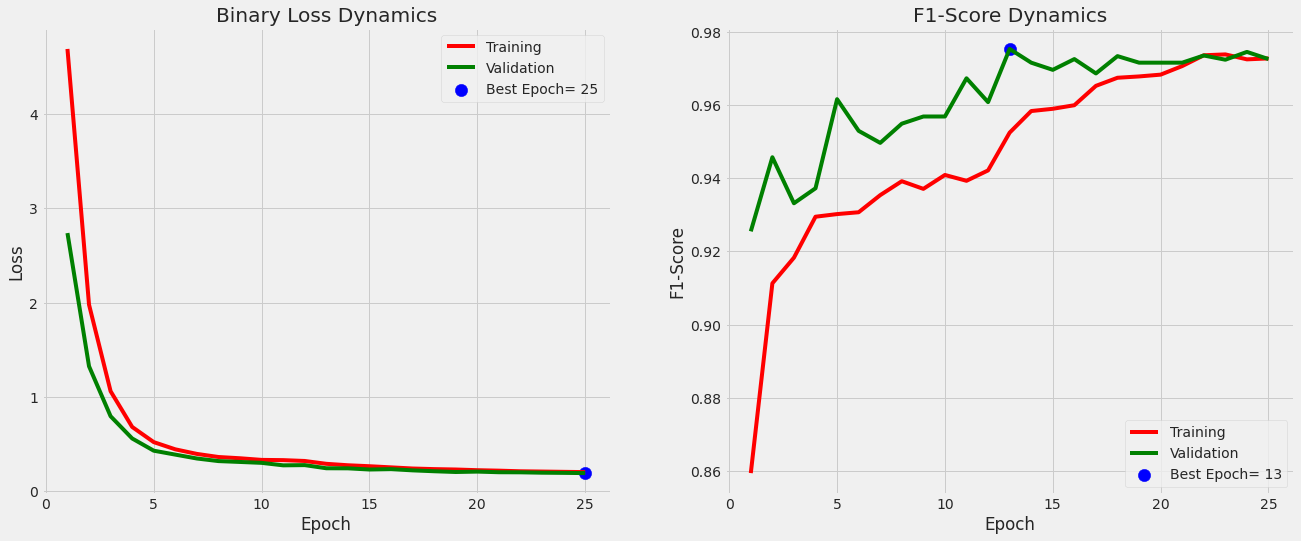

NameError: ignored

In [68]:
tr_plot(history2,0)
subject='brain tumors'
acc=model.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

32/32 [==============================] - 8s 264ms/step
[[0.98275787 0.01724211]
 [0.98854953 0.01145041]
 [0.97812736 0.0218727 ]
 ...
 [0.00363726 0.99636275]
 [0.145724   0.85427606]
 [0.02420832 0.9757917 ]]
[0 0 0 ... 1 1 1]


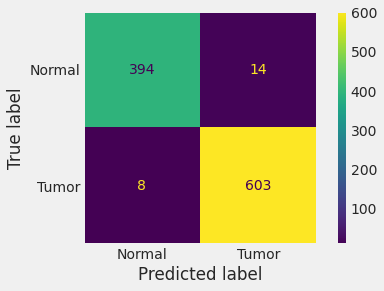

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(test_gen)
print(predictions)
predictedLabels = np.argmax(predictions, axis=1)
print(predictedLabels)
cm = confusion_matrix(test_gen.classes, predictedLabels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_gen.class_indices.keys())

disp.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

In [78]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve


In [81]:
preds = model.predict(test_gen,
verbose=1)
preds

32/32 [==============================] - 8s 264ms/step


array([[0.98275787, 0.01724211],
       [0.98854953, 0.01145041],
       [0.97812736, 0.0218727 ],
       ...,
       [0.00363726, 0.99636275],
       [0.145724  , 0.85427606],
       [0.02420832, 0.9757917 ]], dtype=float32)

In [84]:
y_pred_keras = model.predict(test_gen).ravel()
y_pred_keras

32/32 [==============================] - 8s 264ms/step


array([0.98275787, 0.01724211, 0.98854953, ..., 0.85427606, 0.02420832,
       0.9757917 ], dtype=float32)

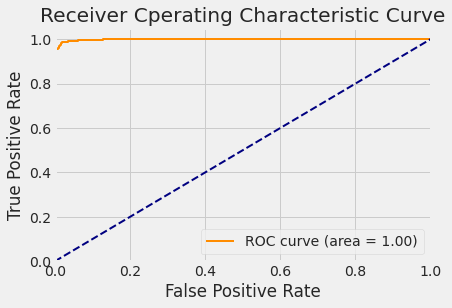

In [88]:
fpr, tpr, _ = roc_curve(test_gen.classes, preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Cperating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [77]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)

ValueError: ignored

In [94]:
misclassificationIndexList = []

for i, p in enumerate(predictedLabels):     
    true_label=test_gen.classes[i]  # labels are integer values
    if p != true_label: # a misclassification has occurred
      misclassificationIndexList.append(test_gen.filenames[i]) 

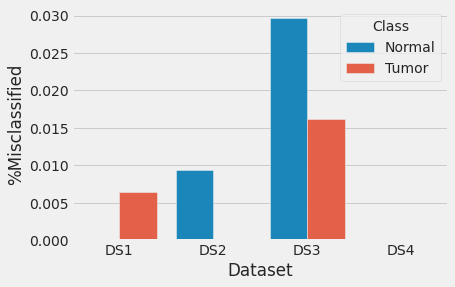

In [104]:
DS4_len = len([s for s in test_gen.filenames if "DS4" in s])
DS3_len = len([s for s in test_gen.filenames if "DS3" in s])
DS2_len = len([s for s in test_gen.filenames if "DS2" in s])
DS1_len = len([s for s in test_gen.filenames if "DS1" in s])


d = {'Dataset': ["DS1", "DS1", "DS2","DS2","DS3", "DS3","DS4", "DS4"],
     '%Misclassified': [0/DS1_len, 2/DS1_len, 3/DS2_len,0/DS2_len,11/DS3_len, 6/DS3_len,
                       0/DS4_len, 0/DS4_len],
     'Class': ["Normal", "Tumor", "Normal", "Tumor","Normal", "Tumor","Normal", "Tumor"]}
df = pd.DataFrame(data=d)
sns.barplot(data=df, x="Dataset", y="%Misclassified", hue="Class")

In [105]:
model.save("/content/gdrive/MyDrive/FAI/ENB4_BrainTumorClassifier.h5")

In [96]:
misclassificationIndexList
#DS4 0
#DS3 11 + 6
#DS2 3 + 0
#DS1 0 + 2

['Normal/DS2_T0_C0_image (42).jpg',
 'Normal/DS2_T0_C0_image(111).jpg',
 'Normal/DS2_T0_C0_image(126).jpg',
 'Normal/DS3_T0_Image1144.jpg',
 'Normal/DS3_T0_Image1147.jpg',
 'Normal/DS3_T0_Image1428.jpg',
 'Normal/DS3_T0_Image1570.jpg',
 'Normal/DS3_T0_Image1939.jpg',
 'Normal/DS3_T0_Image2110.jpg',
 'Normal/DS3_T0_Image2667.jpg',
 'Normal/DS3_T0_Image3296.jpg',
 'Normal/DS3_T0_Image3593.jpg',
 'Normal/DS3_T0_Image65.jpg',
 'Normal/DS3_T0_Image852.jpg',
 'Tumor/DS1_T1_y1375.jpg',
 'Tumor/DS1_T1_y1461.jpg',
 'Tumor/DS3_T1_Image1312.jpg',
 'Tumor/DS3_T1_Image1460.jpg',
 'Tumor/DS3_T1_Image2831.jpg',
 'Tumor/DS3_T1_Image3038.jpg',
 'Tumor/DS3_T1_Image3173.jpg',
 'Tumor/DS3_T1_Image3258.jpg']

50/50 [==============================] - 11s 170ms/step


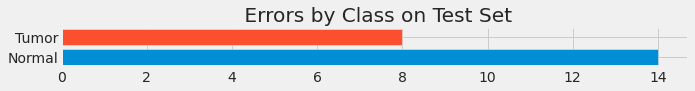

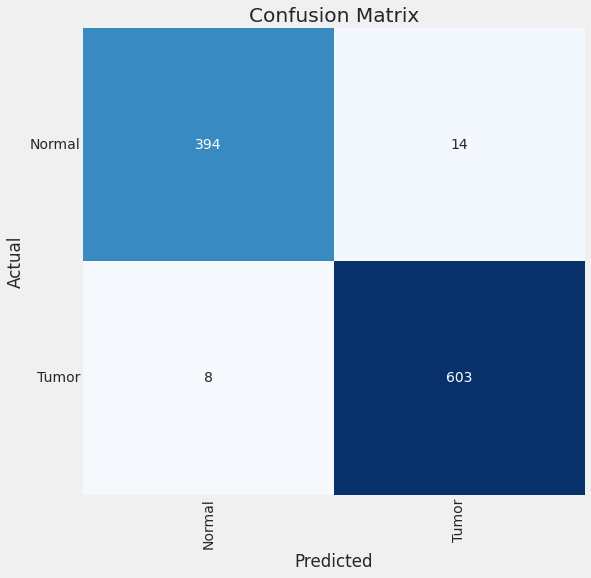

Classification Report:
----------------------
               precision    recall  f1-score   support

      Normal       0.98      0.97      0.97       408
       Tumor       0.98      0.99      0.98       611

    accuracy                           0.98      1019
   macro avg       0.98      0.98      0.98      1019
weighted avg       0.98      0.98      0.98      1019



In [69]:
print_code=0
subject='brain tumors'

preds=model.predict(test_gen, steps=num_test//batch_size, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject ) 

In [31]:
img_size=(224,224)
channels=3
batch_size=20
img_shape=(img_size[0], img_size[1], channels)

gen=ImageDataGenerator(ImageDataGenerator(rescale = 1./255))

train_gen=gen.flow_from_directory(directory = train, target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen=gen.flow_from_directory(directory = test, target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

valid_gen=gen.flow_from_directory(directory = val, target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [33]:
model_name='VGG16'
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                                include_top=False, weights="imagenet")
base_model.trainable = False
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(2, activation='softmax', name="pred")(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy',f1_score])

In [28]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [34]:
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler


#callback to stop the training if your validation accuracy is not increased in last 2 epochs
callback1 = EarlyStopping( monitor="val_accuracy",
                           patience=2,
                           verbose=1,
                           mode="auto",
                           min_delta=0 )

#callback to decay learning based on below conditions 
#Cond1. If validation accuracy at that epoch is less than previous epoch accuracy, decrease the learning rate by 10%. 
#Cond2. For every 3rd epoch, decay learning rate by 5%
#for Cond1:-
callback2 = ReduceLROnPlateau( monitor="val_accuracy",
                              factor=0.1,
                              patience=1,
                              verbose=1,
                              mode="auto"
                              )
#for Cond2:-
def lf_schedule(epoch,lr):
  if epoch%3 ==0:
    lr=lr - 0.05*lr #-->i.e. 0.95*lr (5% decay)
    print(f'New learning rate for epoch={epoch} is {lr}')
    return lr
  else:
    return lr
callback3 = LearningRateScheduler( schedule=lf_schedule,verbose=1 )

#callback to save the model at every epoch if validation accuracy is improved from previous epoch
#file path to save the best model for ModelCheckPoint:-

f_path = "/content/gdrive/MyDrive/FAI/best_modelVGG16.h5"
callback4 = ModelCheckpoint( filepath=f_path,
                             monitor="val_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="auto"
                           )

In [35]:
historyVGG16 = model.fit_generator(generator=train_gen,
                              steps_per_epoch=len(train_gen),
                              validation_data=valid_gen,
                              validation_steps=len(valid_gen),
                              epochs=30,
                              callbacks=[callback1,callback2,callback3,callback4])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 1: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/30


<ipython-input-35-eaac09a03f6a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyVGG16 = model.fit_generator(generator=train_gen,


ValueError: ignored

In [ ]:
epochs = 5
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=15 # number of epochs to run before asking if you want to halt training
batches=num_train//batch_size
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

historyVGG16 = model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

References:

 - https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

 - https://ai.plainenglish.io/beginners-guide-to-transfer-learning-with-simple-example-using-vgg16-61040c095ab9

 - https://medium.com/nerd-for-tech/image-classification-using-transfer-learning-vgg-16-2dc2221be34c

 - https://medium.com/mlearning-ai/brain-tumor-detection-transfer-learning-using-vgg16-a0d0a31f2e9

 - https://www.kaggle.com/code/gpiosenka/efficientnetb4-acc-score-99-67#Create-EfficientNetB4-Model

 - https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

 - https://towardsdatascience.com/10-minutes-to-building-a-fully-connected-binary-image-classifier-in-tensorflow-d88062e1247f

 - https://github.com/streamlit

 - https://paperswithcode.com/method/efficientnet#:~:text=EfficientNet%20is%20a%20convolutional%20neural,resolution%20using%20a%20compound%20coefficient.


